In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
import pickle
from scipy.spatial.distance import cdist
import scipy
from scipy.stats import zscore
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

import anndata as an
import scanpy as sc
import scanpy.external as sce
import rapids_singlecell as rsc
import scvi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 3

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 338 ms, sys: 1.22 s, total: 1.56 s
Wall time: 7min 2s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'cluster'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'batch_colors', 'cluster_colors', 'dr

In [3]:
adata.obs['batch'].value_counts()

batch
hsc    8357
fib    6960
Name: count, dtype: int64

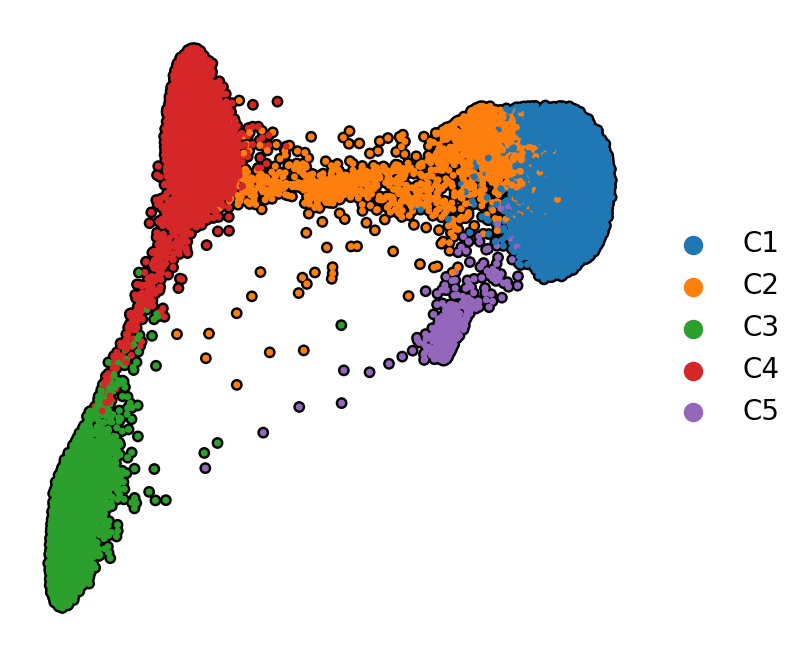

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['cluster_str'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    wspace=0.5,
)

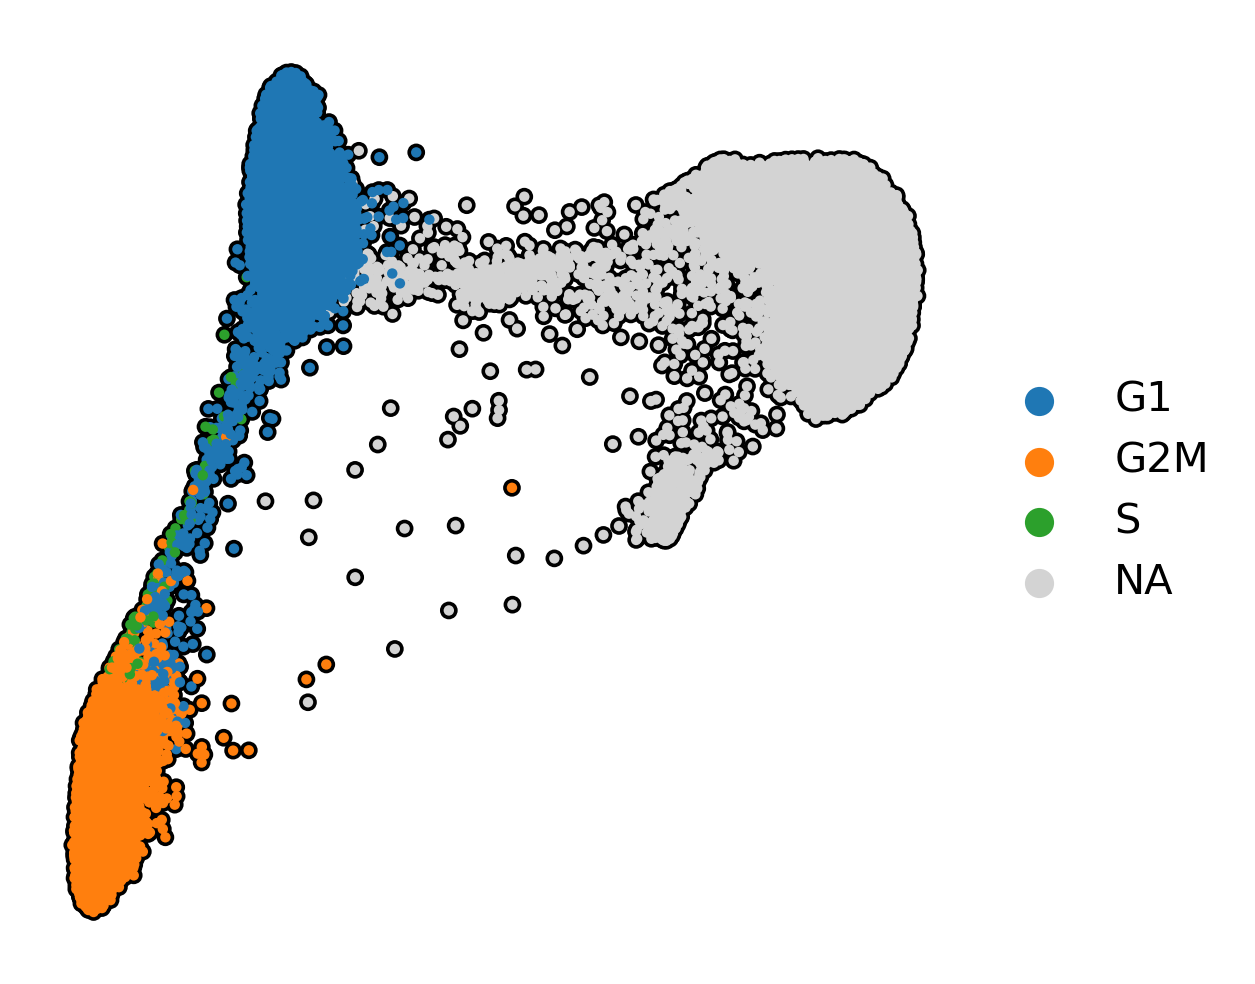

In [6]:
mask = adata.obs['cluster_str'].isin(['C3', 'C4'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['phase'],
    mask_obs=mask,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    # legend_loc='none',
    wspace=0.5,
)

# Score cell cycle genes

In [5]:
regev_genes = [x.strip() for x in open('/home/jrcwycy/githubrepositories/hybrid_reprogramming/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
    layer='log_norm',   
)

adata.obs[['phase']].head()

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    384 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


phase
AAACCCAAGGTTACCT-1_hsc    G1
AAACCCAAGTTGAAGT-1_hsc    G1
AAACCCAAGTTGTCGT-1_hsc     S
AAACCCACAGAAGCGT-1_hsc    G1
AAACCCACAGGAGGTT-1_hsc    G1

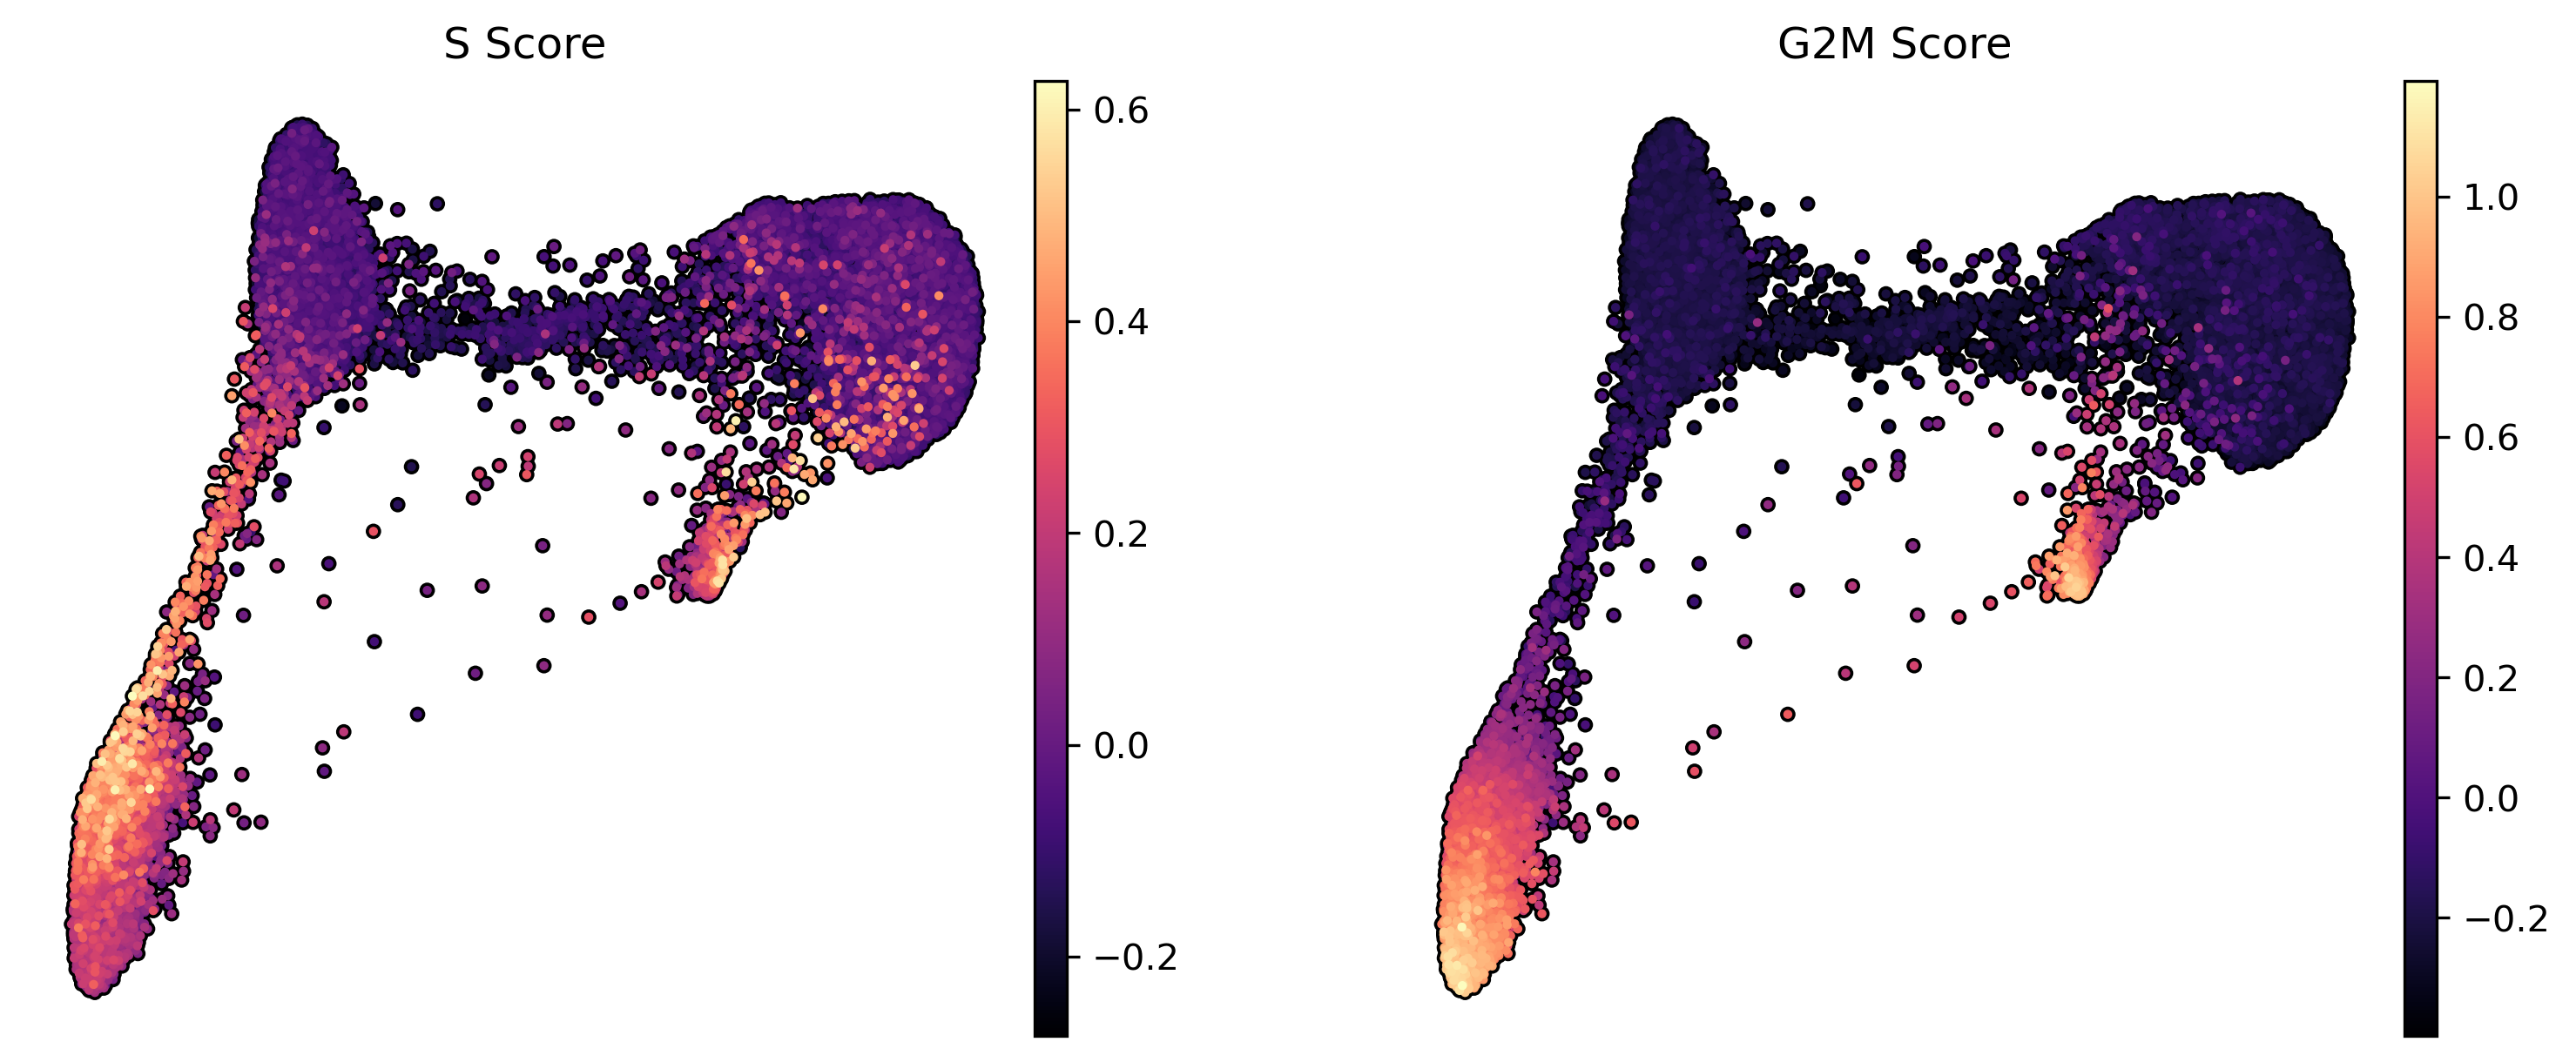

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.75, 4.75

sc.pl.draw_graph(
    adata, 
    # mask_obs=(adata.obs['batch'] == 'fib'),
    color=['S_score', 'G2M_score',],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    cmap='magma',
    outline_color=('k', 'k'),
    title=['S Score', 'G2M Score'],
    frameon=False,
    wspace=0.25,
)

# Pseudotime

In [16]:
def find_closest_cell(adata, obs_key='phase', value='G1', obsm_key='X_pca', dataset_key='dataset', dataset=None):
    """
    Find the cell closest to a median vector in PCA space for a given group and optional dataset.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group.
        value (str): The value for aggregation (e.g., 'G1').
        obsm_key (str): Key in adata.obsm for PCA or other embedding (e.g., 'X_pca').
        dataset_key (str): Key in adata.obs for selecting grouping
        dataset (str, optional): Name of dataset in adata.obs[dataset_key] to restrict search.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest matching cell in adata.obs_names.
    """
    mask = adata.obs[obs_key] == value
    if dataset is not None:
        mask &= adata.obs[dataset_key] == dataset

    emb = adata.obsm[obsm_key][mask]
    
    if emb.shape[0] == 0:
        raise ValueError("No cells match the specified filters.")

    median_vec = np.median(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index

In [15]:
# bdata = adata.copy()

# sc.pp.neighbors(bdata, use_rep='X_pca_harmony')
# sc.tl.diffmap(bdata)

# for phase, cluster in zip(['G1', 'G2M'], ['C4', 'C5']):
#     root_idx, root_key = find_closest_cell(
#         adata,
#         obs_key='cluster',
#         obsm_key='X_pca_harmony',
#         value=cluster,
#     )

#     print(f"{phase}: {root_idx=} {root_key=}")
    
#     # set root and run pseudotime
#     bdata.uns["iroot"] = root_key
#     sc.tl.dpt(bdata, n_branchings=2, allow_kendall_tau_shift=True)

#     bdata.obs[f'{phase}_pseudotime'] = bdata.obs['dpt_pseudotime']
#     bdata.obs[f'{phase}_order'] = bdata.obs['dpt_order']
    
    
# bdata.obs['mean_pseudotime'] = bdata.obs[['G1_pseudotime', 'G2M_pseudotime']].mean(axis=1)
# bdata.obs['mean_order'] = bdata.obs[['G1_order', 'G2M_order']].mean(axis=1)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# palette = {
#     "G1": "#D73027",        # strong red (Cdt1+)
#     "S": "#1A9850",         # green (Geminin+)
#     "G2M": "#FDAE61",       # orange-yellow (Cdt1+/Geminin+)
#     "unknown": "#B0B0B0", # Neutral gray
# }

# sc.pl.draw_graph(
#     bdata, 
#     color=['phase', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime'],
#     size=25,
#     ncols=2,
#     alpha=1,
#     use_raw=False,
#     na_in_legend=False,
#     add_outline=True,
#     outline_color=('k', 'k'),
#     palette=palette,
#     title=['Phase', 'G1 Pseudotime', 'G2M Pseudotime', 'Mean G1/G2M Pseudotime'],
#     frameon=False,
# )

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.998412   0.9940781  0.9863367  0.97860056 0.9736288
     0.96751904 0.9560099  0.95527923 0.9454243  0.9401936  0.9397273
     0.93582267 0.93266034 0.9271766 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
G1: root_idx='AGAGAATCATTCGCTA-1_fib' root_key=np.int64(9410)
computing Diffusion Pseudotime using n_dcs=10
    this uses a hierarchical implementation
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:06)
G2M: root_idx='CGT

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.998412   0.9940781  0.9863367  0.97860056 0.9736288
     0.96751904 0.9560099  0.95527923 0.9454243  0.9401936  0.9397273
     0.93582267 0.93266034 0.9271766 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
G1: cell_id='AGAGAATCATTCGCTA-1_fib' root_idx=np.int64(9410)
computing Diffusion Pseudotime using n_dcs=10
    this uses a hierarchical implementation
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:06)
G2M: cell_id='CGTAA

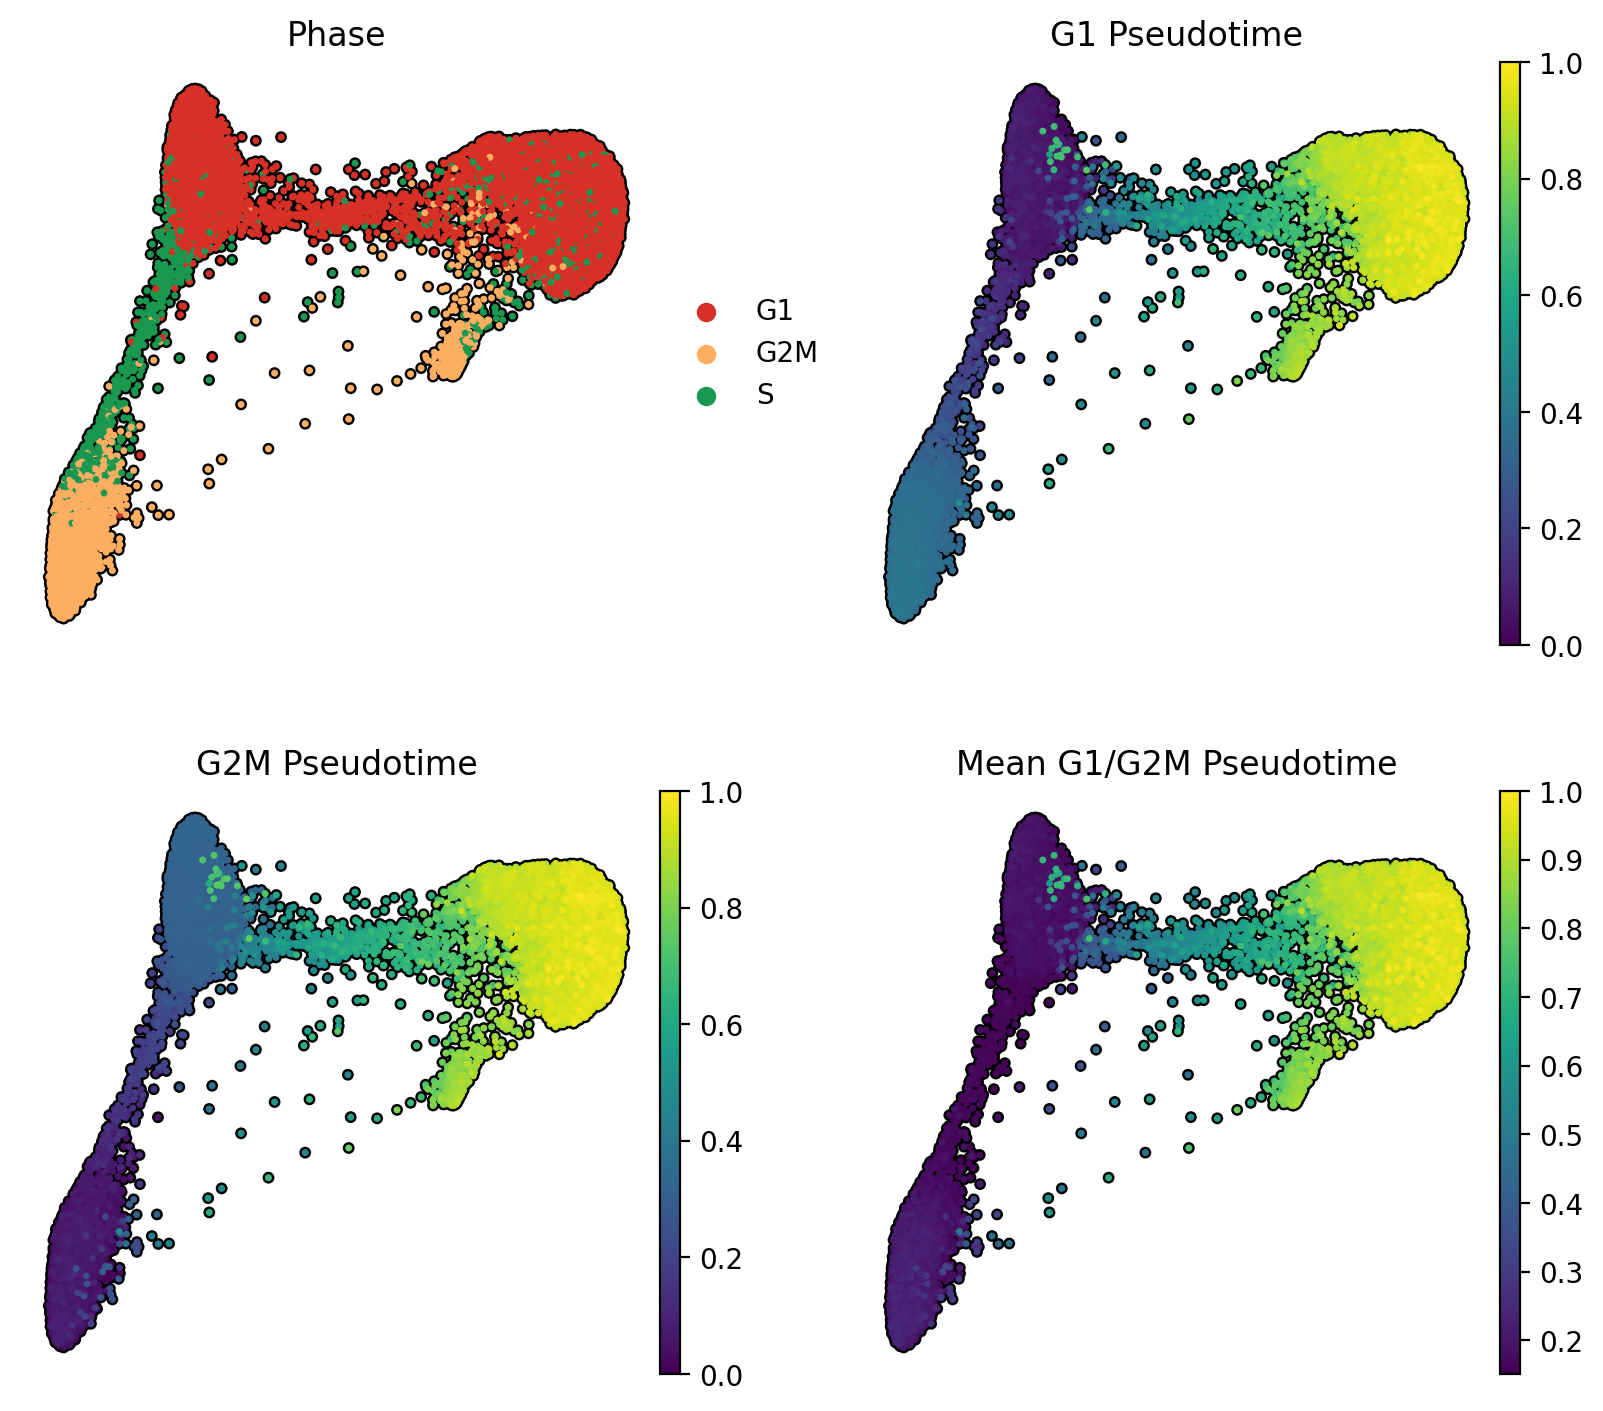

In [18]:
bdata = adata.copy()

sc.pp.neighbors(bdata, use_rep='X_pca_harmony')
sc.tl.diffmap(bdata)

for phase in ['G1', 'G2M']:

    # choose representative cells from either G1 or G2M
    cell_id, root_idx = find_closest_cell(
        bdata, 
        obs_key='phase', 
        value=phase,
        obsm_key='X_pca_harmony',
        dataset_key='batch',
        dataset='fib',
    )

    print(f"{phase}: {cell_id=} {root_idx=}")

    # set root and run pseudotime
    bdata.uns["iroot"] = root_idx
    sc.tl.dpt(bdata, n_branchings=2, allow_kendall_tau_shift=True)

    bdata.obs[f'{phase}_pseudotime'] = bdata.obs['dpt_pseudotime']
    bdata.obs[f'{phase}_order'] = bdata.obs['dpt_order']
    
    
bdata.obs['mean_pseudotime'] = bdata.obs[['G1_pseudotime', 'G2M_pseudotime']].mean(axis=1)
bdata.obs['mean_order'] = bdata.obs[['G1_order', 'G2M_order']].mean(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

palette = {
    "G1": "#D73027",        # strong red (Cdt1+)
    "S": "#1A9850",         # green (Geminin+)
    "G2M": "#FDAE61",       # orange-yellow (Cdt1+/Geminin+)
    "unknown": "#B0B0B0", # Neutral gray
}

sc.pl.draw_graph(
    bdata, 
    color=['phase', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime'],
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    na_in_legend=False,
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    title=['Phase', 'G1 Pseudotime', 'G2M Pseudotime', 'Mean G1/G2M Pseudotime'],
    frameon=False,
)

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    bdata, 
    color=['G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime'],
    size=25,
    ncols=3,
    alpha=1,
    cmap='inferno',
    use_raw=False,
    na_in_legend=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title=['G1 Pseudotime', 'G2M Pseudotime', 'Mean G1/G2M Pseudotime'],
    frameon=False,
    colorbar_loc=None,
)

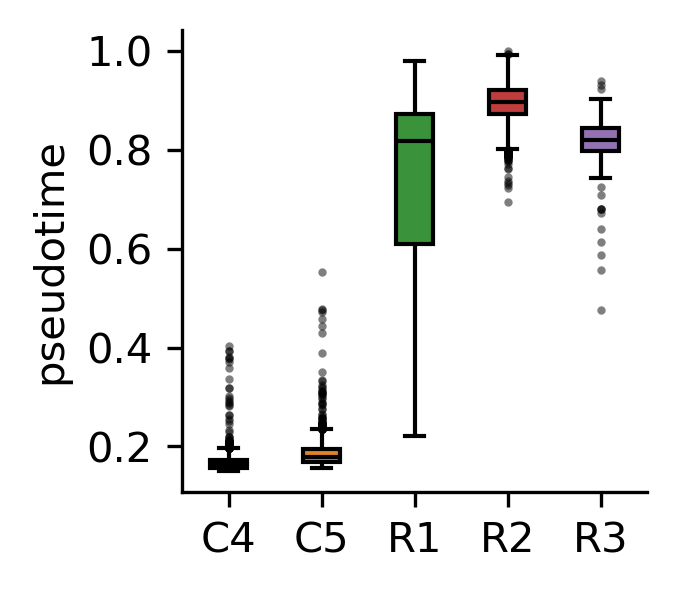

In [19]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

sns.boxplot(
    data=bdata.obs,
    x='cluster',
    y='mean_pseudotime',
    width=0.4,
    linecolor='k',
    hue='cluster',
    legend=False,
    flierprops={'markersize' : 1, 'alpha' : 0.5}
)

plt.xlabel("")
plt.ylabel("pseudotime")

sns.despine()

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    bdata, 
    color=['mean_pseudotime'],
    size=25,
    cmap='inferno',
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    colorbar_loc=None,
    wspace=0.5,
)

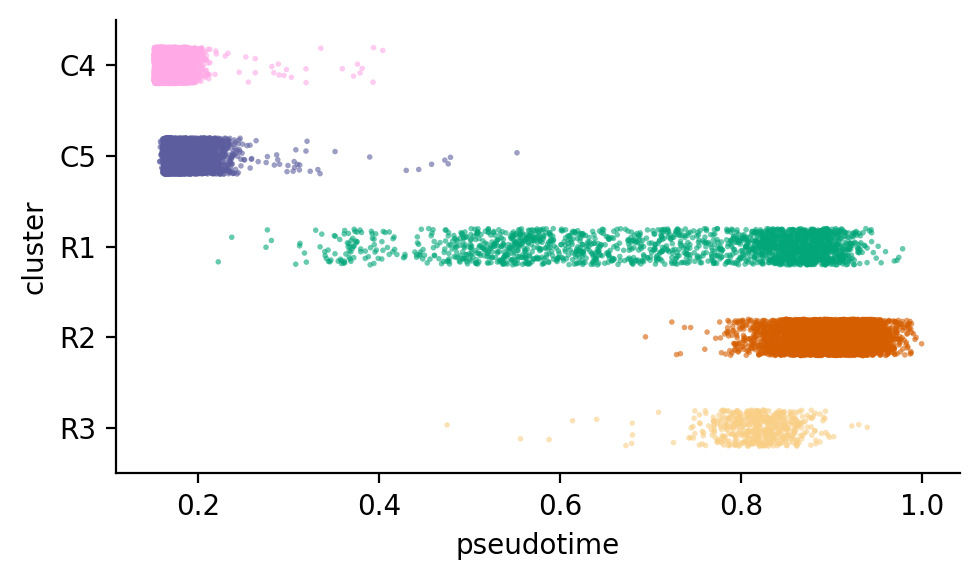

In [46]:
# dot plot over pseudotime
df = pd.DataFrame({
        'pseudotime' : bdata.obs['mean_pseudotime'].values,
        'cell_id': bdata.obs_names,
        'cluster' : bdata.obs['cluster'].values,
    })

df = df.sort_values(by='pseudotime', ascending=True)

df.head()

palette = bdata.uns['cluster_colors']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.stripplot(
    data=df,
    x='pseudotime',
    y='cluster',
    hue='cluster',
    size=2,
    jitter=0.2,
    alpha=0.6,
    linewidth=0,
    palette=palette,
)

sns.despine()
plt.tight_layout()
plt.show()

# Write out

In [9]:
# outpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/new_pseudotime.h5ad"
# bdata.write(outpath)
# bdata

AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances

# Correlation

In [10]:
%%time
df = bdata.obs.copy()

# add genes
df = pd.concat([df, bdata.to_df()], axis=1)

pseudo_col = 'mean_pseudotime' 

# filter data
df = df[np.isfinite(df[pseudo_col])].copy()
df['dpt_rank'] = df[pseudo_col].rank()

results = []
for gene in tqdm(bdata.var_names, desc="Computing Pearson Correlation"):
    corr, pval = scipy.stats.pearsonr(df[pseudo_col], df[gene])
    results.append({
        'gene' : gene,
        'corr' : corr,
        'pval' : pval,
    })

results = pd.DataFrame(results)
results['adj_p_value'] = multipletests(results['pval'], method='fdr_bh')[1]
results = results.sort_values('corr', ascending=False)

print("="*20 + " Positive Correlation " + "="*20)
print(results.head(15).to_string(index=False))
print()
print("="*20 + " Negative Correlation " + "="*20)
print(results.tail(15).to_string(index=False))

Computing Pearson Correlation: 100%|██████████| 23434/23434 [01:19<00:00, 296.01it/s] 

==================== Positive Correlation ====================
     gene     corr  pval  adj_p_value
    KRT18 0.915950   0.0          0.0
      MGP 0.912605   0.0          0.0
      CLU 0.890294   0.0          0.0
     FLNB 0.852953   0.0          0.0
IGFL2-AS1 0.835834   0.0          0.0
  SLC12A8 0.821564   0.0          0.0
   S100A6 0.814332   0.0          0.0
  SLC44A1 0.805861   0.0          0.0
LINC00842 0.801908   0.0          0.0
    TPST2 0.793147   0.0          0.0
  S100A10 0.788466   0.0          0.0
    KRT19 0.750066   0.0          0.0
     RBP1 0.750035   0.0          0.0
   AHNAK2 0.727415   0.0          0.0
     NSG1 0.723684   0.0          0.0

==================== Negative Correlation ====================
     gene      corr  pval  adj_p_value
   TSPAN9 -0.764152   0.0          0.0
TNFRSF11B -0.765976   0.0          0.0
      MX1 -0.772410   0.0          0.0
   EPSTI1 -0.775915   0.0          0.0
    IFIT3 -0.794283   0.0          0.0
    STAT1 -0.807126   0.0      

In [14]:
results1 = results.copy()

gtf = adata.var[['gene_type']].copy()
gtf = gtf.reset_index(names='gene')

results1 = pd.merge(results1, gtf, how='left', on='gene')
print(results1.shape)

results1 = results1[results1['gene_type'] == 'protein_coding']
results1 = results1[~results1['gene'].str.startswith(('ENSG', 'MT-'))]

print(results1.shape)
results1.head()

(23434, 5)
(15001, 5)


gene      corr  pval  adj_p_value       gene_type
0    KRT18  0.915950   0.0          0.0  protein_coding
1      MGP  0.912605   0.0          0.0  protein_coding
2      CLU  0.890294   0.0          0.0  protein_coding
3     FLNB  0.852953   0.0          0.0  protein_coding
5  SLC12A8  0.821564   0.0          0.0  protein_coding

In [15]:
top_n = 25
top = results1.nlargest(top_n, 'corr').copy()
top = top.sort_values("corr")  # ensure genes are in order from low to high

plt.figure(figsize=(3.5, 4.5))
ax = plt.gca()

# Draw lines from y-axis to each dot (baseline = 0)
for i, (gene, corr) in enumerate(zip(top['gene'], top['corr'])):
    ax.hlines(
        y=i,
        xmin=0,
        xmax=corr,
        color='lightgray',
        linewidth=1.25,
        zorder=0,
    )

# Draw the dots
scatter = ax.scatter(
    top['corr'],
    range(len(top)),
    c=top['corr'],
    cmap='viridis',
    edgecolor='black',
    s=60,
    zorder=3,
)

# Format axes
ax.set_yticks(range(len(top)))
ax.set_yticklabels(top['gene'], fontsize=9)
ax.set_xlabel("correlation")
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.tick_params(axis='x', labelsize=9)
ax.set_xlim(0, top['corr'].max() * 1.05)

# Optional colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.4,)
cbar.set_label("correlation")
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

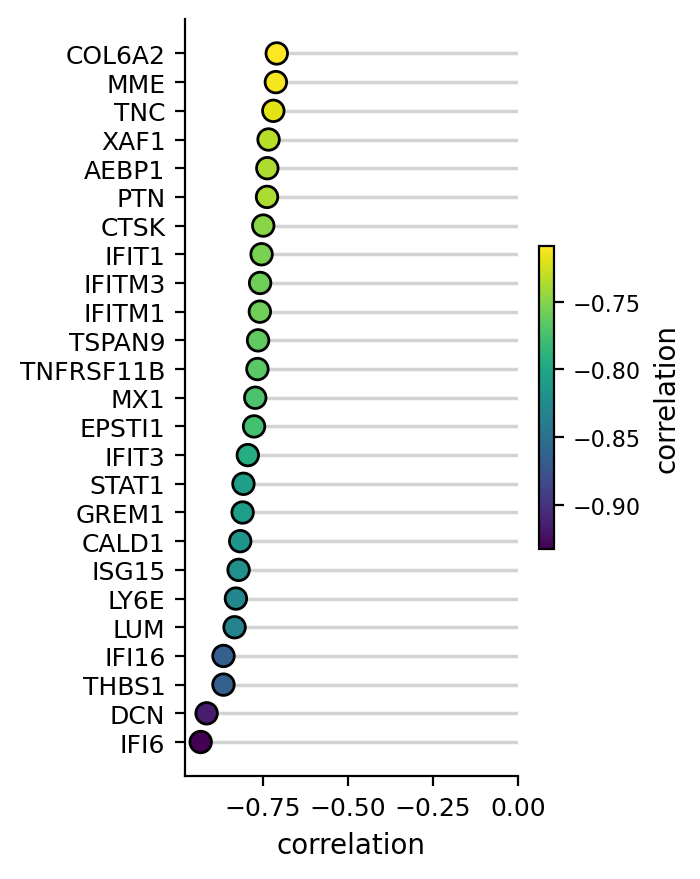

In [16]:
top_n = 25
top = results1.nsmallest(top_n, 'corr').copy()
top = top.sort_values("corr")  # ensure genes are in order from most negative to less negative

plt.figure(figsize=(3.5, 4.5))
ax = plt.gca()

# Draw lines from y-axis to each dot (baseline = 0)
for i, (gene, corr) in enumerate(zip(top['gene'], top['corr'])):
    ax.hlines(
        y=i,
        xmin=0,
        xmax=corr,
        color='lightgray',
        linewidth=1.25,
        zorder=0,
    )

# Draw the dots
scatter = ax.scatter(
    top['corr'],
    range(len(top)),
    c=top['corr'],
    cmap='viridis',
    edgecolor='black',
    s=60,
    zorder=3,
)

# Format axes
ax.set_yticks(range(len(top)))
ax.set_yticklabels(top['gene'], fontsize=9)
ax.set_xlabel("correlation")
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.tick_params(axis='x', labelsize=9)
ax.set_xlim(top['corr'].min() * 1.05, 0)

# Optional colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.4)
cbar.set_label("correlation")
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


## heatmap

In [17]:
from matplotlib import gridspec
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)

bdata.obs['global_ordering'] = bdata.obs['mean_pseudotime'].rank(ascending=True)

50


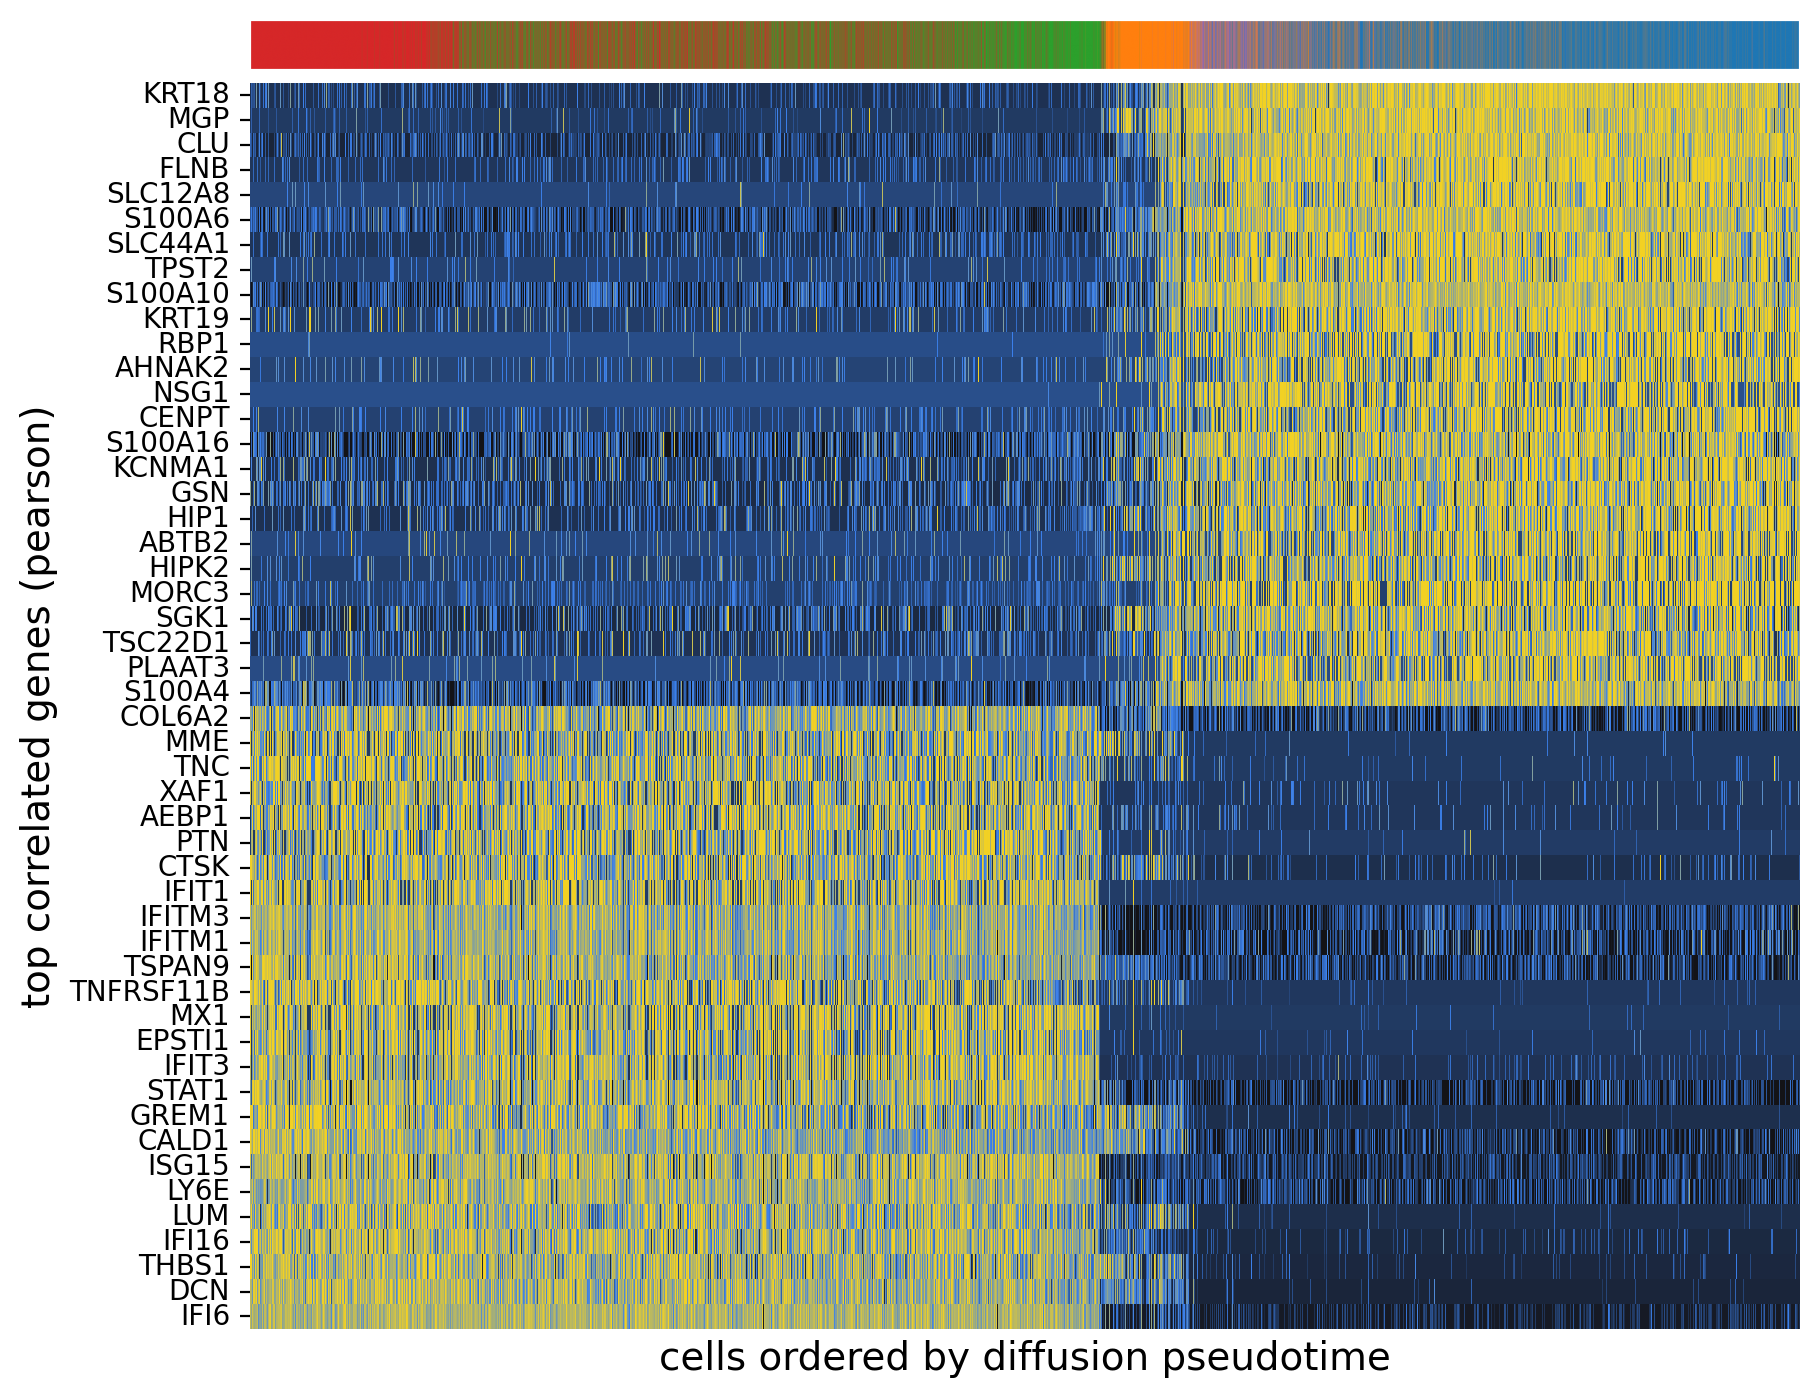

In [21]:
top_n = 25

# get top corr genes
results1 = results1.sort_values(by='corr', ascending=False)
top_pos = results1.head(top_n)
top_pos = top_pos['gene'].unique().tolist()

top_neg = results1.tail(top_n)
top_neg = top_neg['gene'].unique().tolist()

genes = top_pos + top_neg
print(len(genes))


bdata.obs['global_ordering'] = bdata.obs['global_ordering'].astype(int)
cell_order = bdata.obs.sort_values("global_ordering").index
n_cells = len(cell_order)

bdata.X = bdata.layers['log_norm'].copy()

expr = bdata[cell_order, genes].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# z-score expression
expr_z = zscore(expr, axis=0)

# get bar for cluster order
clusters = bdata.obs.loc[cell_order, 'cluster_str']

# mapping: category → color
cluster_colors = dict(zip(
    bdata.obs['cluster_str'].cat.categories,
    bdata.uns['cluster_str_colors']
))

# convert cluster labels to colors for each cell in order
col_colors = clusters.map(cluster_colors).to_numpy()
rgba_colors = np.array([to_rgba(c) for c in col_colors])


fig = plt.figure(figsize=(10, 8.5), dpi=200)

gs = gridspec.GridSpec(
    2, 1, 
    height_ratios=[0.4, 10],   # small top bar, big heatmap
    hspace=0.02                 # small spacing
)

# --- Top colorbar axis (tiny horizontal strip) ---
ax_color = fig.add_subplot(gs[0])

ax_color.imshow(rgba_colors[np.newaxis, :, :], aspect='auto')
ax_color.set_xlim(0, n_cells)
ax_color.set_xticks([])
ax_color.set_yticks([])
for spine in ax_color.spines.values():
    spine.set_edgecolor('white')

ax_heat = fig.add_subplot(gs[1])

sns.heatmap(
    expr_z.T,
    cmap=custom_cmap,
    xticklabels=False,
    yticklabels=genes,
    vmin=-2,
    vmax=2,
    cbar=False,
    ax=ax_heat,
)
ax_heat.set_yticklabels(ax_heat.get_yticklabels(), fontsize=10)
ax_heat.set_xlabel("cells ordered by diffusion pseudotime", fontsize=14)
ax_heat.set_ylabel("top correlated genes (pearson)", fontsize=14)

plt.tight_layout()
plt.show()

## enrichr

In [25]:
pd.set_option('display.max_colwidth', None)

# database = 'celltypes'
# database = "GO_Biological_Process_2025"
# database="KEGG_2021_Human"
# database='MSigDB_Hallmark_2020' 
# database="Reactome_Pathways_2024"
database = "CellMarker_2024"
# database='Tabula_Sapiens'
n_query = 200

edf = gget.enrichr(results1['gene'].head(n_query).unique(), database=database, save=False)
display(edf[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
print("=" * 100 + "\n")

edf = gget.enrichr(results1['gene'].tail(n_query).unique(), database=database, save=False)
display(edf[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
print("=" * 100 + "\n")

19:12:57 - INFO - Performing Enrichr analysis using database CellMarker_2024.
2025-12-08 19:12:57 | [INFO] Performing Enrichr analysis using database CellMarker_2024.


path_name  \
0             Gonadal Endothelial Cell Fetal Gonad Human   
1                            Medullary Cell Kidney Mouse   
2                         Sertoli Cell Fetal Gonad Human   
3                            Monocyte Fetal Kidney Human   
4                            Microglial Cell Brain Human   
5                           Endothelial Cell Ovary Human   
6                            Krt4/13+ Cell Trachea Mouse   
7                                  Basal Cell Lung Human   
8                 Vascular Endothelial Cell Kidney Mouse   
9              Mitotic Fetal Germ Cell Fetal Gonad Human   
10  Fibrocartilage Chondrocyte Articular Cartilage Human   
11         Schwalie Et al.Nature.G3 Adipose Tissue Mouse   
12                            Fibroblast Undefined Mouse   
13         Schwalie Et al.Nature.G1 Adipose Tissue Mouse   
14                  Memory T Cell Peripheral Blood Human   

                                                                                                                                                            overlapping_genes  \
0          [NFAT5, JUP, ANXA2, FBLIM1, DOCK9, PXN, GAB1, CAPG, ASAP1, ASAP2, EFNA5, BLCAP, HIPK2, TPST2, S100A16, OLFML3, REL, ARHGEF3, S100A13, PLXNA2, PMEPA1, CD24, FKBP5]   
1                                                                              [NFAT5, SVIL, SPARC, FBLIM1, PRSS23, TANC1, CCDC80, COL5A1, CUX1, OLFML3, FLNB, CD24, S100A10]   
2                                    [G6PD, JUP, SMIM1, PRUNE2, LAMA3, PLAAT3, CYRIB, CLU, TPST2, NYNRIN, GPRC5B, SEC14L1, PRDX1, REL, FLNB, TRIM16, SLC25A36, S100A10, GAS7]   
3   [DOCK5, SPARC, ANXA2, AHNAK, G0S2, CAPG, IRAK3, CYRIB, LYST, SERPINB6, FGD4, PRDX5, CUX1, PSAP, S100A6, RAC2, BLVRB, TSPO, S100A4, SH3BGRL3, MELTF, S100A10, GAS7, PTGES]   
4                                                                  [CSTB, CAPG, RPS4X, OLFML3, PRDX1, KCNMA1, SH3PXD2B, BHLHE40, TSPO, S100A4, APBB2, CD34, GAS7, FKBP5, FTL]   
5                                                                                                                                             [KRT19, KRT18, MGP, CD24, CD34]   
6                                                                                                         [KRT19, CLIC3, ANXA2, AHNAK, BHLHE40, S100A6, TSPO, CAPG, ARHGAP12]   
7                                                                                                                  [JUP, S100A16, NXN, SH3BGRL3, CAPG, IGFBP6, AQP3, S100A10]   
8                                                                                                [CLIC4, JUP, S100A16, HEG1, SLCO2A1, SH3BP5, APBB2, SGK1, CD24, SMAD6, CD34]   
9                                 [CSTB, GSN, JUP, FBLIM1, SLC39A11, CAPG, BLCAP, AQP3, RPS4X, FGD4, GPRC5B, OLFML3, PSAP, RPUSD3, S100A13, FLNB, APBB2, IGFBP6, UPP1, STRA6]   
10                                                                                                             [CYB5A, CRABP2, COL5A1, AHNAK, OLFML3, S100A4, IGFBP6, PRSS23]   
11                                                                                                          [CSTB, GSN, DOCK9, OLFML3, PRDX1, BHLHE40, MGP, TSPO, S100A4, C2]   
12                                                                                                                                             [SPARC, COL5A1, S100A4, FBLN2]   
13                                                                                                  [RPS4X, ALDH1A3, CYB5A, AHNAK, GFPT2, ZBTB16, HEG1, AHNAK2, PRSS23, GAS7]   
14                                                                                                                                                  [S100A6, S100A4, S100A10]   

       adj_p_val  
0   1.645421e-07  
1   3.304067e-06  
2   2.368960e-05  
3   1.937627e-04  
4   3.248254e-04  
5   3.248254e-04  
6   3.248254e-04  
7   4.134736e-04  
8   4.134736e-04  
9   6.358805e-04  
10  7.479986e-04  
11  7.871548e-04  
12  7.

19:12:58 - INFO - Performing Enrichr analysis using database CellMarker_2024.
2025-12-08 19:12:58 | [INFO] Performing Enrichr analysis using database CellMarker_2024.


path_name  \
0          Schwalie Et al.Nature.G4 Adipose Tissue Mouse   
1                Leydig Precursor Cell Fetal Gonad Human   
2                            Medullary Cell Kidney Mouse   
3                                  Fibroblast Skin Mouse   
4          Schwalie Et al.Nature.G2 Adipose Tissue Mouse   
5   Fibrocartilage Chondrocyte Articular Cartilage Human   
6                     Exhausted CD8+ T Cell Breast Human   
7              Mitotic Fetal Germ Cell Fetal Gonad Human   
8                            Mesangial Cell Kidney Mouse   
9                                 Fibroblast Heart Mouse   
10         Schwalie Et al.Nature.P1 Adipose Tissue Mouse   
11                    Endothelial Cell Fetal Gonad Human   
12                         Plasma Cell Nasopharynx Human   
13                    Goblet Cell Intestinal Crypt Mouse   
14                      Granulosa Cell Fetal Gonad Human   

                                                                                                                                                                                                                                         overlapping_genes  \
0             [IFITM3, SP100, ELN, UBE2L6, IFI35, IFIT1, SAMHD1, THBS2, IFIT3, GJA1, RNF213, RPL13, RPL37, RPS2, HSP90AA1, STAT1, CAVIN3, STAT2, EIF2AK2, RPSA, ISG15, RPL23A, BST2, DNAJA1, RPS25, RPL27A, PSME1, PSME2, RPS20, CD248, FXYD5, XAF1, LY6E]   
1                                                      [RPL10, RPL31, C1R, ELN, RND3, FSTL1, PLAC9, IFI16, MDK, CALD1, TMSB4X, RPL13, CTSC, PDGFRA, NEGR1, IGFBP5, TPM2, TPM1, BGN, RPL13A, NR2F2, SULF1, DCN, COL3A1, CXCL12, COL6A2, CDH11, COL6A1, VIM]   
2                                                                             [TAGLN, TNC, NEXN, RRBP1, NREP, THBS2, FSTL1, THBS1, MYLK, HSP90B1, CLMP, TMSB4X, PDGFRA, NEGR1, TPM1, BGN, ATP2B1, DCN, COL3A1, CXCL12, COL4A2, LOX, COL4A1, CDH11, COL6A1]   
3                                                                                                                      [PDGFRA, TAGLN, IGFBP5, PRRX1, LUM, ELN, TPM2, THBS2, SULF1, CKAP4, DCN, PLAC9, COL3A1, CXCL12, LOX, COL6A2, COL6A1, COL6A3, CD248]   
4                                                                                      [TAGLN, TPM4, MME, LUM, TPM2, ARID5B, RRBP1, NREP, NR2F2, GNG11, CKAP4, COL3A1, CLMP, COL4A2, IFI27, COL4A1, CALD1, MDK, CTSK, COL6A2, CDH11, ENPP2, SLIT2, CTHRC1]   
5                                                                                                         [PDGFRA, IFITM2, IGFBP5, PRRX1, LAMA4, CAVIN3, TPM1, IFI6, PTN, SULF1, GNG11, CXCL12, COL4A2, IFI27, IFI16, COL4A1, TMSB4X, PSME1, COL6A3, LY6E]   
6                                                                                                                                                                                [IFITM3, BST2, IFI27, OAS1, MX1, IFI6, IFI44, ISG15, IFI44L, IFIT3, LY6E]   
7   [FKBP11, IFITM3, IFITM1, RPL31, PTN, FSTL1, EFEMP1, IFI16, CCDC85B, CALD1, TMSB4X, RPL13, RPL38, RPL37, RPS2, CTSC, PNPT1, TPM4, TPM2, TPM1, ARID5B, RPL13A, RPSA, RPL23A, RPS25, FRMD6, COL4A2, RPS29, COL4A1, RPL27A, PSME2, VIM, PFN1, RPL28, LY6E]   
8                                                                                                                  [APP, TAGLN, CITED2, CAVIN3, TPM2, TPM1, ARID5B, HSPB1, PTN, ARPC5, GNG11, MYLK, CSRP2, FRMD6, COL4A2, COL4A1, CALD1, CD248, VIM, PFN1]   
9                                                                                                                                                                                          [PDGFRA, COL3A1, LOX, BGN, PTN, VIM, FSTL1, CKAP4, DCN, CTHRC1]   
10                                                                                                                                [IGFBP5, PRRX1, RPL31, ELN, RPL23A, THBS2, SULF1, RPS25, RPS29, TMSB4X, RPL37A, RPL13, RPS20, CD248, RPL37, RPS2, RPS11]   
11                                    

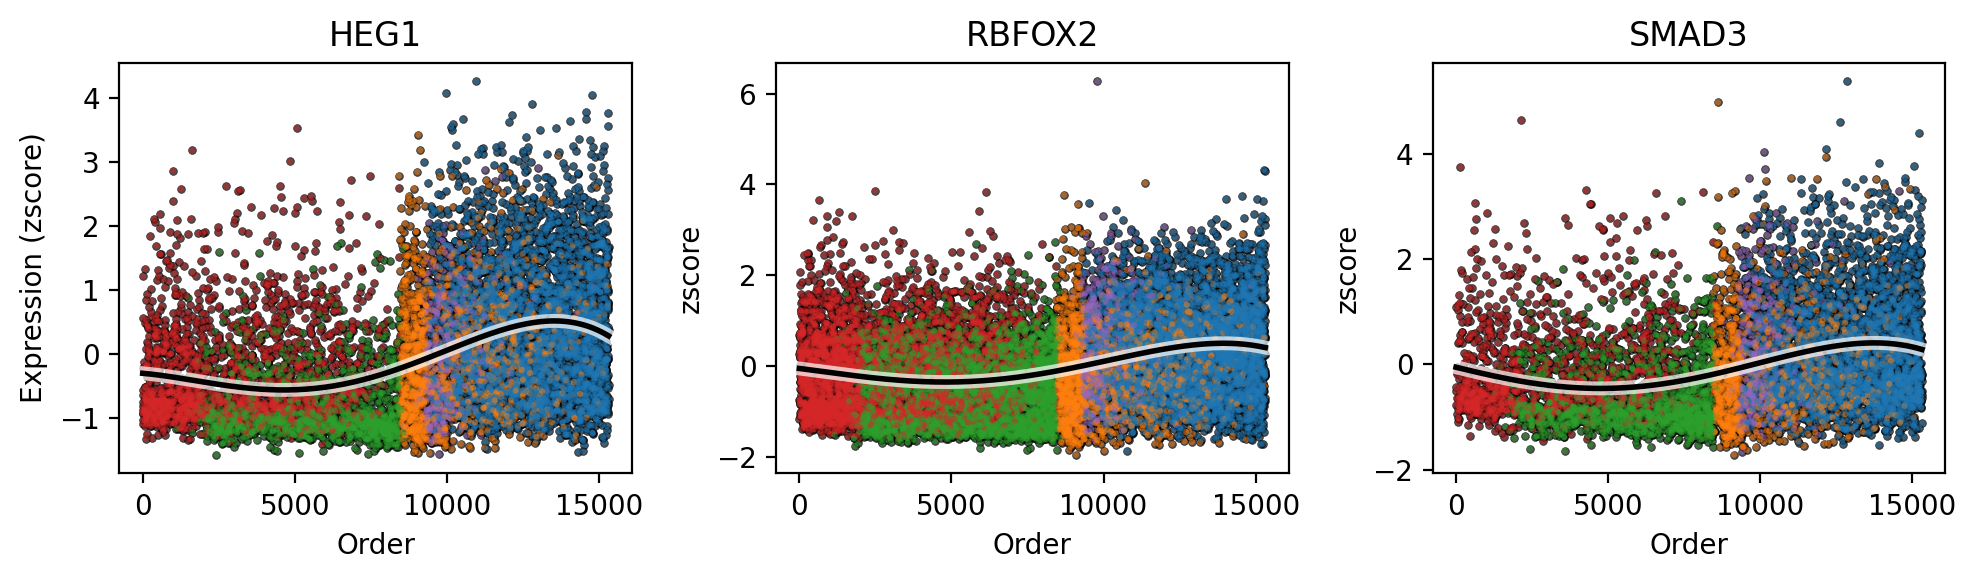

In [34]:
layer = 'log_norm'

gene_names = [
    "HEG1", "RBFOX2",  "SMAD3"  
]

gene_names = [g for g in gene_names if g in bdata.var_names]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

fig, axes = plt.subplots(1, 3)
axes = axes.ravel()

for i, gene in enumerate(gene_names):
    
    pdf = pd.DataFrame({
        'global_ordering' : bdata.obs['global_ordering'].values,
        'cluster' : bdata.obs['cluster_str'].values,
        'expression' : bdata[:, gene].layers[layer].toarray().ravel(),
    })

    # filter zero expression
    pdf = pdf[pdf['expression'] > 0].copy()
    
    pdf['zscore'] = zscore(pdf['expression'])
    
    
    # y = adata[:, gene].layers[layer].toarray().ravel()  
    # y = zscore(y)
    # x = adata.obs['global_ordering'].values

    sns.scatterplot(
        x=pdf['global_ordering'],
        y=pdf['zscore'],
        s=8,
        #x=x,y=y,s=8,
        ec='k',c='k',
        alpha=0.7,
        ax=axes[i]
    )

    sns.scatterplot(
        x=pdf['global_ordering'],
        y=pdf['zscore'],
        s=5,
        # x=x,y=y,s=5,
        ec='none',
        # palette=palette,
        legend=False,
        alpha=0.5,
        hue=pdf['cluster'],
        # hue=adata.obs[f'cluster_str'],
        ax=axes[i]
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("Order")

    if i == 0:
        axes[i].set_ylabel("Expression (zscore)")

    # degree=4 polyfit
    coeffs = np.polyfit(pdf['global_ordering'], pdf['zscore'], deg=4)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(pdf['global_ordering'].min(), pdf['global_ordering'].max(), 200)
    y_fit = p(x_fit)

    # error estimate from residuals
    residuals = pdf['zscore'] - p(pdf['global_ordering'])
    err = residuals.std()
    y_lower = y_fit - err
    y_upper = y_fit + err

    axes[i].plot(x_fit, y_fit, lw=5, color="w", alpha=0.7)
    axes[i].plot(x_fit, y_fit, lw=2, color="k")
    # axes[i].fill_between(x_fit, y_lower, y_upper, color="k", alpha=0.2)

# fig.suptitle(layer.upper(), fontsize=18, y=1.0)
plt.tight_layout()

# TFs

In [35]:
fpath = "/home/jrcwycy/githubrepositories/hematokytos/resources/allTFs_hg38.txt"
tf_list = [x.strip() for x in open(fpath)]
tf_list[:10]

tdf = results[results['gene'].isin(tf_list)]
print("="*20 + " Positive Correlation " + "="*20)
print(tdf.head(15).to_string(index=False))
print()
print("="*20 + " Negative Correlation " + "="*20)
print(tdf.tail(15).to_string(index=False))

==================== Positive Correlation ====================
   gene     corr  pval  adj_p_value
  PRDX5 0.663913   0.0          0.0
  ZFHX3 0.632184   0.0          0.0
 ZBTB16 0.609707   0.0          0.0
    REL 0.549299   0.0          0.0
  RPS4X 0.494267   0.0          0.0
  YWHAZ 0.489994   0.0          0.0
 ZNF706 0.485332   0.0          0.0
  NCOA3 0.460735   0.0          0.0
  NFAT5 0.456076   0.0          0.0
   NFIC 0.449353   0.0          0.0
BHLHE40 0.443679   0.0          0.0
   CUX1 0.441062   0.0          0.0
 ZNF827 0.426345   0.0          0.0
 SETBP1 0.425765   0.0          0.0
   MSI2 0.417670   0.0          0.0

==================== Negative Correlation ====================
   gene      corr  pval  adj_p_value
  HMGB1 -0.467786   0.0          0.0
   DAB2 -0.496471   0.0          0.0
    NMI -0.502986   0.0          0.0
SMARCA5 -0.517506   0.0          0.0
  HSPA5 -0.549821   0.0          0.0
  SP100 -0.552598   0.0          0.0
  NR2F2 -0.553409   0.0          0.0
 

/tmp/ipykernel_900025/3084184122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['y_jitter'] = np.random.normal(loc=0, scale=0.1, size=len(tdf))
2025-12-08 17:09:18 | [WARNING] Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


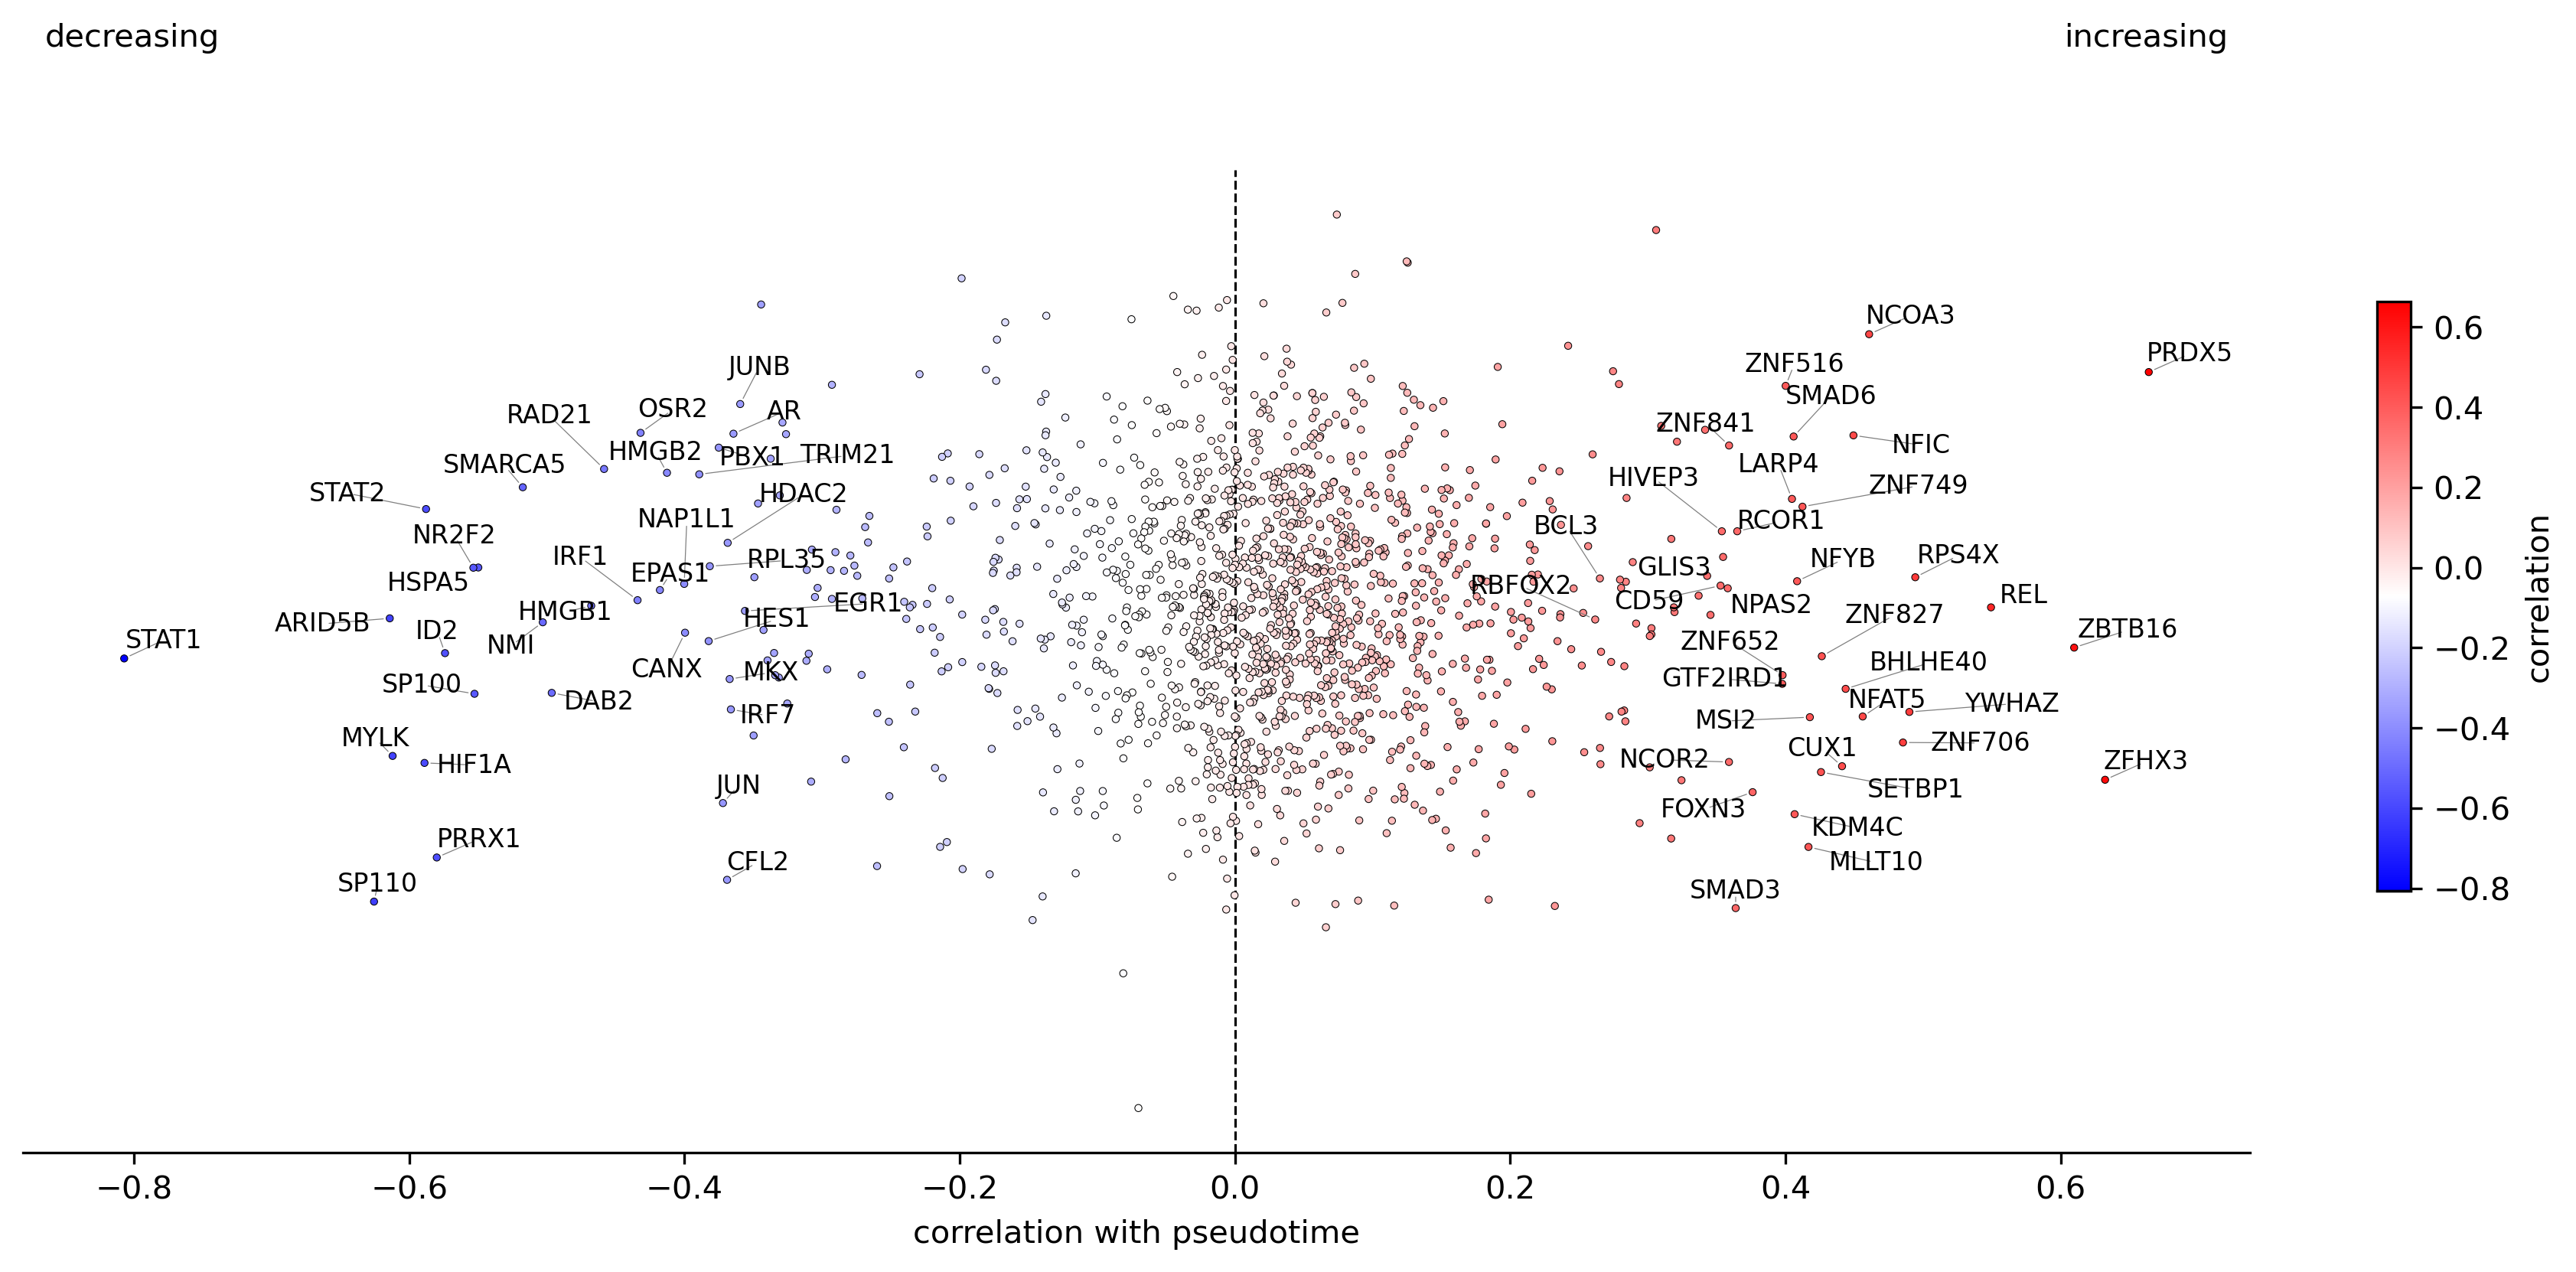

In [36]:
# # Manually create jittered y-values
tdf['y_jitter'] = np.random.normal(loc=0, scale=0.1, size=len(tdf))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Plot scatter
sc = sns.scatterplot(
    data=tdf,
    x='corr',
    y='y_jitter',
    hue='corr',
    palette='bwr',
    edgecolor='k',
    linewidth=0.25,
    s=5,
    legend=False,
    zorder=3,
    ax=ax
)

genes_to_include = ['RBFOX2', 'BCL3', 'JUN']

# Annotate genes with large correlations
texts = []
target_x = []
target_y = []
for _, row in tdf[(abs(tdf['corr']) > 0.35) | (tdf['gene'].isin(genes_to_include))].iterrows(): # 0.35
    texts.append(ax.text(
        row['corr'],
        row['y_jitter'],
        row['gene'],
        fontsize=8,
        ha='center',
        va='bottom',
        zorder=4
    ))
    target_x.append(row['corr'])
    target_y.append(row['y_jitter'])

adjust_text(
    texts,
    target_x=target_x,
    target_y=target_y,
    expand_text=(1.2, 2),
    avoid_self=True,
    ax=ax,
    arrowprops=dict(arrowstyle='-', lw=0.3, color='gray'),
    force_text=(0.75, 0.75),
)

# Add colorbar centered on right margin
norm = Normalize(vmin=tdf['corr'].min(), vmax=tdf['corr'].max())
sm = ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])

# Use bbox_to_anchor to shift right
cax = inset_axes(
    ax,
    width="1.5%", height="60%",
    bbox_to_anchor=(1.05, 0.25, 1, 1),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left'
)
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('correlation')

# Plot formatting
ax.axvline(x=0, c='k', lw=0.75, ls='--', zorder=0)
ax.set_xlabel('correlation with pseudotime')
ax.set_ylabel('')
ax.set_yticks([])
sns.despine(left=True)
plt.tight_layout()

# Direction labels
ax.text(0.01, 1.15, "decreasing", transform=ax.transAxes, ha='left', va='top', fontsize=10)
ax.text(0.99, 1.15, "increasing", transform=ax.transAxes, ha='right', va='top', fontsize=10)

plt.show()

# z-score plots

2025-12-08 17:10:21 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-08 17:10:21 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-08 17:10:21 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-08 17:10:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-08 17:10:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

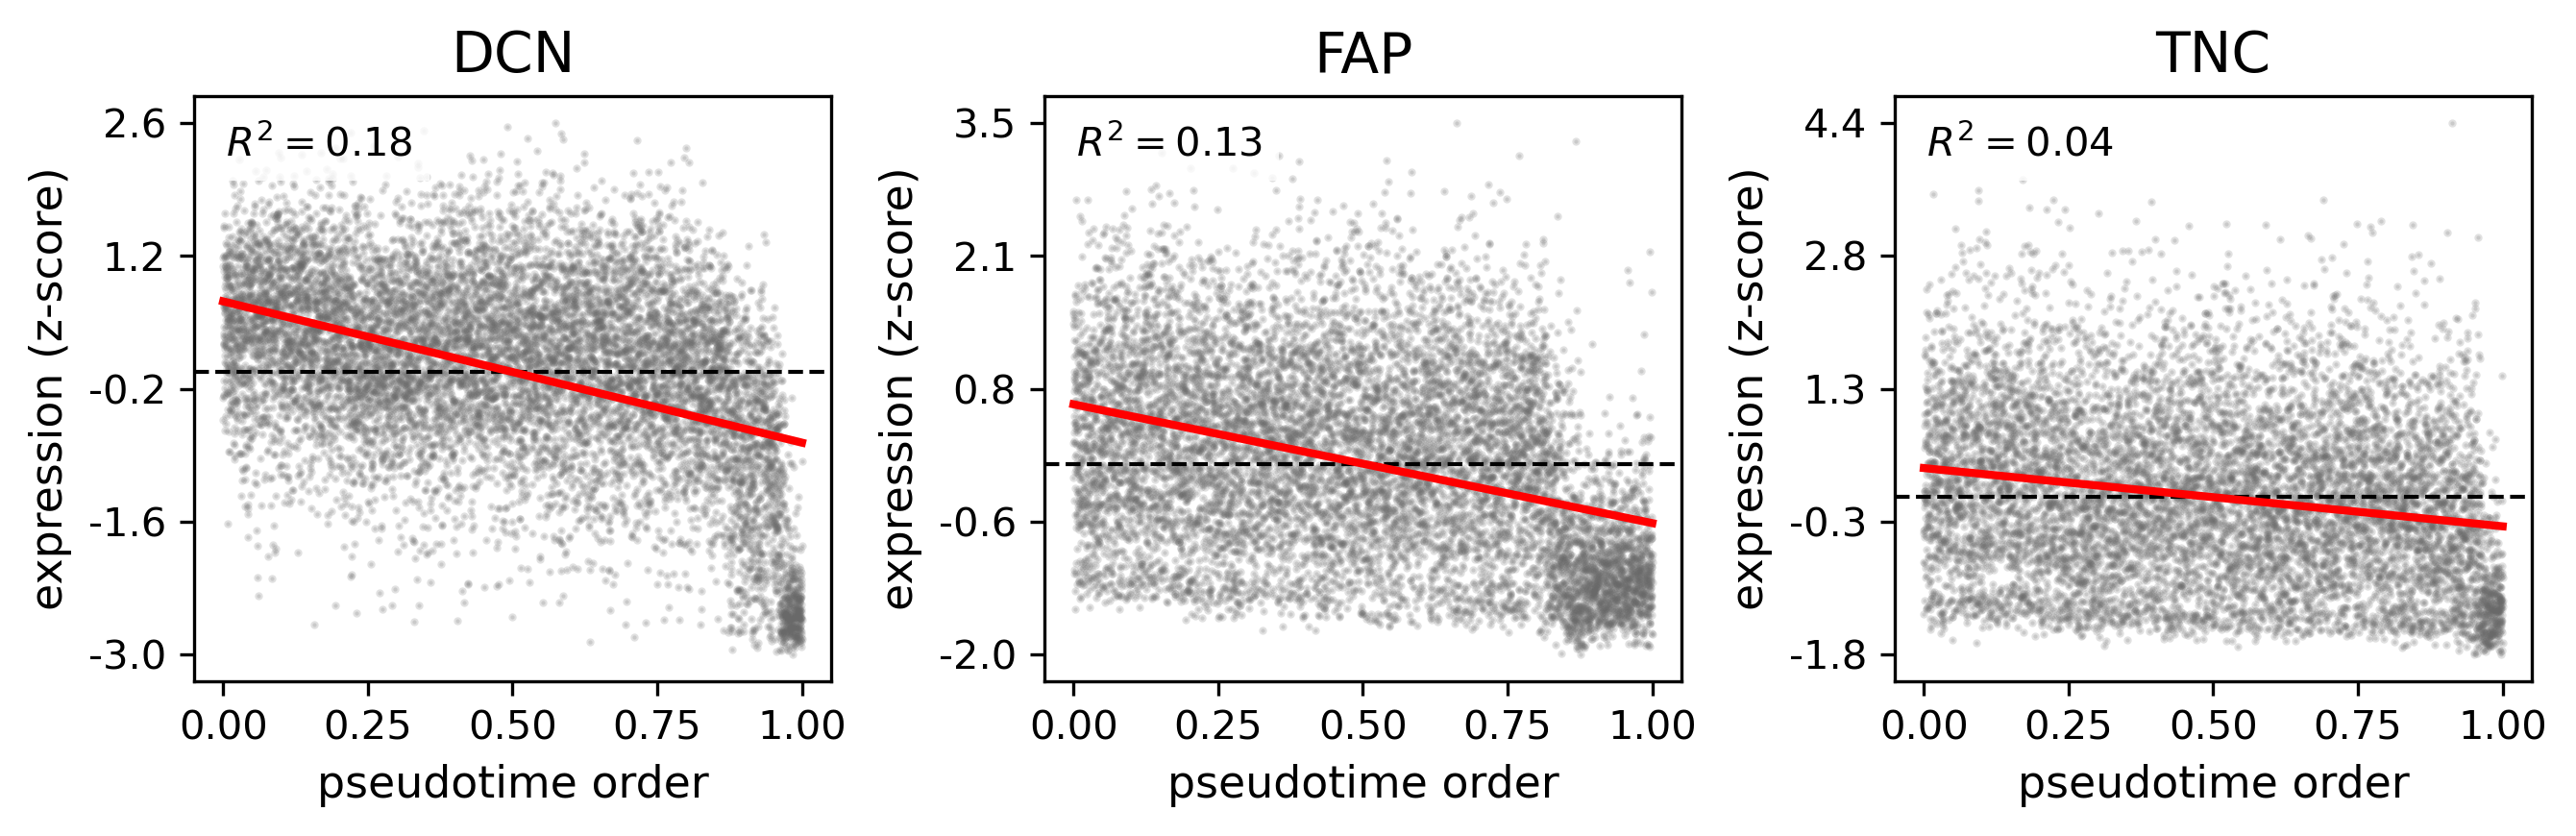

In [37]:
genes = [
    # "TSPAN9",
    # "FLNB",     # Endothelial/HSC – Surface glycoprotein, marks endothelial progenitors and HSCs
    # "EGFR",     # Endothelial – Growth factor receptor, active in vasculature and epithelium
    # "CBFA2T2",  # HSC – Corepressor interacting with RUNX1, active in early hematopoiesis
    # 'STMN1',
    # 'MKI67',
    # 'TOP2A',
    # 'DUT',
    # 'EGFR',
    
    # 'HEG1', # Endothelial – Transmembrane protein enriched in vascular endothelium
    # 'RBFOX2', # stemness regulator (UP)
    # 'SMAD3', 
    
    # 'FBLN2', # ECM protein (UP)
    'DCN', # fibroblast/ECM gene (DOWN)
    # 'FSTL1', # fibroblast activation, wound repair, fibrosis (DOWN)
    # 'TSPAN9', # fibroblast express it (DOWN)
    # 'COL4A1', # ECM component (DOWN)
    'FAP', # fibroblast (DOWN)
    'TNC'
    # 'ITGA6', # CD49f (UP)
]


plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 14, 3
# fig, axs = plt.subplots(1, 4)
plt.rcParams['figure.figsize'] = 9, 3
fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, gene in enumerate(genes):
    axs[i].axhline(y='0', lw=1, c='k', ls='--')

    # Build dataframe
    pdf = pd.DataFrame({
        'pseudotime' : bdata.obs['mean_pseudotime'].values,
        'cluster' : bdata.obs['cluster_str'].values,
        'expression' : bdata[:, gene].X.toarray().ravel(),
    })

    # filter zero expression
    pdf = pdf[pdf['expression'] > 0].copy()
    
    pdf[f'zscore'] = zscore(pdf['expression'])
    pdf['order'] = pdf['pseudotime'].rank() / len(pdf)
    pdf = pdf.sort_values(by='pseudotime').reset_index(drop=True)

    # Compute regression
    slope, intercept, r_value, p_value, std_err = linregress(pdf['order'], pdf['zscore'])

    # Plot with regression line and CI
    sns.regplot(
        data=pdf,
        x='order',
        y='zscore',
        scatter_kws={'s': 1, 'color': 'dimgray', 'alpha': 0.2},
        line_kws={'color': 'r', 'lw':2},
        # lowess=True,
        # x_bins=50,
        n_boot=100,
        ax=axs[i],
    )
    
    # Annotate regression stats
    axs[i].text(
        0.05, 0.95,
        f"$R^2 = {r_value**2:.2f}$",
        transform=axs[i].transAxes,
        verticalalignment='top',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    yticks = np.linspace(pdf['zscore'].min(), pdf['zscore'].max(), 5)
    yticklabels = [f"{y:.1f}" for y in yticks]
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(yticklabels)

    axs[i].set_title(gene, fontsize=14)
    axs[i].set_ylabel('expression (z-score)', fontsize=11)
    axs[i].set_xlabel('pseudotime order', fontsize=11)


plt.tight_layout()